In [1]:
import torchvision
import torchvision.datasets as datasets 
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch
import torch.optim as optim
import torch.nn as nn
import numpy as np
import os 
import matplotlib.pyplot as plt
import time 

In [2]:
current_dir = os.path.dirname(os.path.abspath(''))
data_dir = os.path.join(current_dir, 'final', 'data')
print(data_dir)
if not os.path.exists(data_dir): 
    os.makedirs(data_dir)

/home/hgiang/2022_coding/neural-network-1/final/data


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


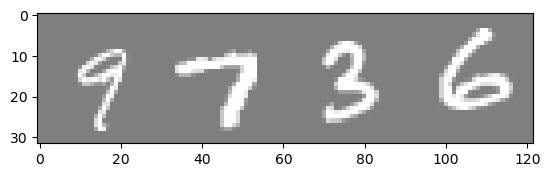

    9     7     3     6


In [4]:
batch_size=4

transform = transforms.ToTensor()

# Get MNIST data, normalize, divide by level 
mnist_train = datasets.MNIST(root=data_dir, train=True, download=True, transform=transform)
testset = datasets.MNIST(root=data_dir, train=False, download=True, transform=transform)

trainloader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, pin_memory=True)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, pin_memory=True)

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{labels[j]:5}' for j in range(batch_size)))

In [5]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(784, 10)

    def forward(self, x):
        x = self.linear(x)
        return x

net = Net()
net.to(device)

Net(
  (linear): Linear(in_features=784, out_features=10, bias=True)
)

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001)

size = len(trainloader.dataset)
num_batches = len(trainloader)

running_losses = []
eval_every = 2000
num_epochs = 5 

start_time_s = time.time()
for epoch in range(num_epochs):  # loop over the dataset multiple times
    running_loss = 0.0

    for batch, data in enumerate(trainloader):
        inputs, labels = data
        inputs = inputs.to(device=device)
        labels = labels.to(device=device)
        inputs = inputs.view(-1, 784)

        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        pred = net(inputs)
        loss = criterion(pred, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if batch % eval_every == (eval_every-1):    # print every 20 mini-batches
            running_loss = running_loss / eval_every
            # print(f'[{epoch + 1}, {batch + 1:5d}] loss: {running_loss:.3f}')
            running_losses.append(running_loss)
            running_loss = 0.0

time_s = (time.time() - start_time_s)/num_epochs
print('Finished Training, training time = {} s'.format(time_s))

Finished Training, training time = 6.316279315948487 s


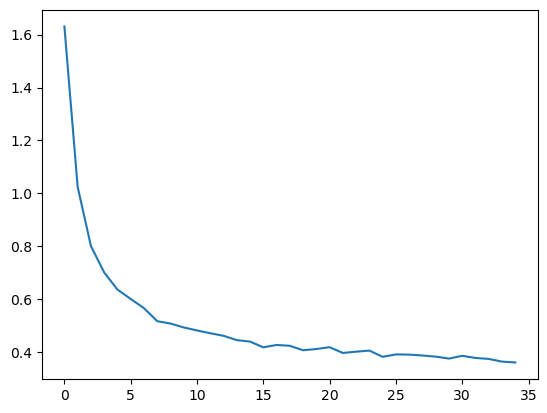

In [7]:
plt.plot(running_losses)

In [8]:
current_dir = os.path.dirname(os.path.abspath(''))
model_path = os.path.join(current_dir, 'final', 'mnist_net.pth')
torch.save(net.state_dict(), model_path)

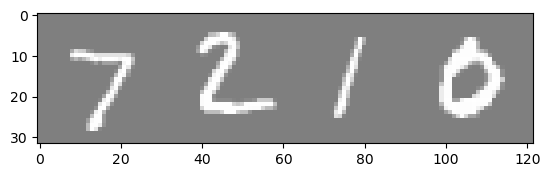

GroundTruth:      7     2     1     0


In [9]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{labels[j]:5}' for j in range(4)))

In [15]:
net = Net()
net.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [16]:
outputs = net(images.view(-1, 784))
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{predicted[j]:5}' for j in range(4)))

Predicted:      3     4     5     6


In [12]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs

start_time_s = time.time()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images.view(-1, 784))
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

time_s = (time.time() - start_time_s)
print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')
print('Finished Testing, testing time = {} s'.format(time_s))

Accuracy of the network on the 10000 test images: 90 %
Finished Testing, testing time = 1.278014898300171 s


In [13]:
# print model summary 
from torchsummary import summary

net.to(device)
# You need to define input size to calcualte parameters
summary(net, input_size = (4, 784), batch_size = batch_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [4, 4, 10]           7,850
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.05
Forward/backward pass size (MB): 0.00
Params size (MB): 0.03
Estimated Total Size (MB): 0.08
----------------------------------------------------------------


In [31]:
n_classes = 10 
n_inputs = 784

def confusion_matrix(preds, labels, conf_matrix):
    preds = torch.argmax(preds, 1)
    for p, t in zip(preds, labels):
        conf_matrix[p, t] += 1
    return conf_matrix

conf_matrix = torch.zeros(n_classes, n_classes)
for data, target in testloader:
    output = net(data.view(-1, n_inputs))
    conf_matrix = confusion_matrix(output, target, conf_matrix)

# convert torch tensor to numpy array 
conf_matrix = conf_matrix.cpu().detach().numpy()

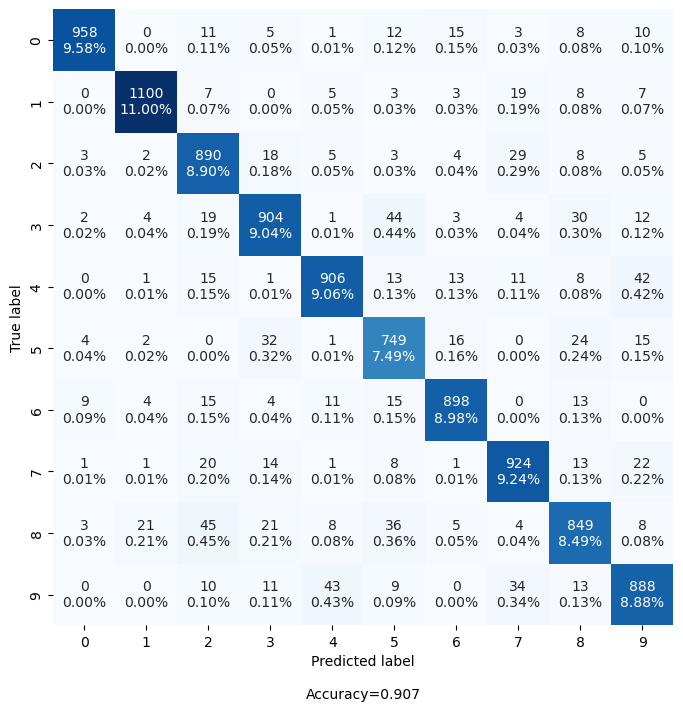

In [52]:
import cf_matrix
import matplotlib.pyplot as plt 

cf_matrix.make_confusion_matrix(conf_matrix, figsize=(8, 8), cbar=False)
plt.savefig('conf_matrix.png')